# Datasets & DataLoders

 - Pytorch는 `torch.utils.data.DataLoader`, `torch.utils.data.Dataset` 두 가지 데이터 primitives를 제공함.
 - `Dataset`는 samples과 상응하는 labels를 저장함.
 - `DataLoader`는 samples을 쉽게 access하기 위해 Dataset에 반복 가능한 항목을 wrapping 함.


### Loading a Dataset

ex) we use FashionMNIS Dataset
parameters:
 - `root` : `root` is the path where the train/test data is stored
 - `train` : `train` specifies training or test dataset
 - `download=True` : `download=True` downloads the data from the internet if it's not available at root
 - `trainform`, `target_transform` : `trainform` and `target_transform` specify the feature and label transformations

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:32<00:00, 818168.80it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 97972.24it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 453482.54it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7192630.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [8]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Iterating and Visualizing the Dataset

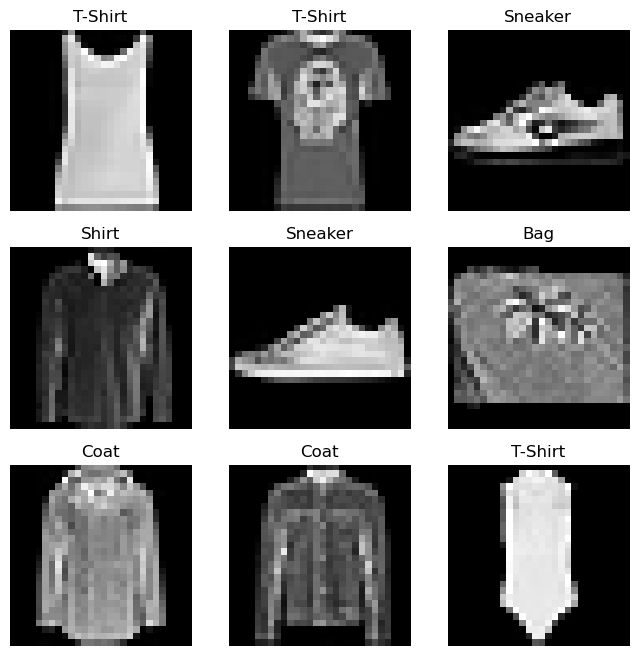

In [7]:
# we can index `Datasets` manually like a list: `training_data[index]`.
# we use `matplotlib` to visualize some samples in our training data

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에 대한 사용자 정의 데이터 세트 만들기

사용자 정의  Dataset class는 __init__, __len__ and __getitem__ 3가지 함수로 구현해야 함.

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## `__init__`
 - `__init__` 함수는 Dataset 개체를 인스턴스화 할 때 한번 실행함.
 - 이미지, 주석 파일 및 두 변환이 모두 포함된 디렉터리를 초기화

In [13]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels=pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

## `__len__`
 - `__len__` 함수는 Dataset의 samples 수를 return

In [14]:
def __len__(self):
    return len(self.img_labels)

## `__getitem__`
 - `__getitem__` 함수는 지정된 인덱스 `idx`에 있는 데이터세트에서 샘플을 로드하고 반환
 - 인덱스 기반으로 디스크에서 이미지의 위치 식별
 - `read_image` 함수로 Tensor로 변환
 - `self.img_labels`의 csv data에서 해당 labels 검색하고 변환 함수를 호출하고 tensor 이미지를 return

In [15]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## DataLoaders를 사용하여 훈련할 데이터 준비

In [20]:
#class torch.utils.data.DataLoader(
#    dataset, batch_size=1, shuffle=None, sampler=None, 
#    batch_sampler=None, num_workers=0, collate_fn=None, 
#    pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, 
#    multiprocessing_context=None, generator=None, *, prefetch_factor=None, persistent_workers=False, pin_memory_device='')

### DataLoader parameter:
 - `dataset`(Dataset) : 불러온 데이터세트
 - `batch_size`(int): batch 마다 얼마나 많은 samples을 load 할건지
 - `shuffle`(bool): eopch마다 data를 다시 섞을지
 - ...

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 반복

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


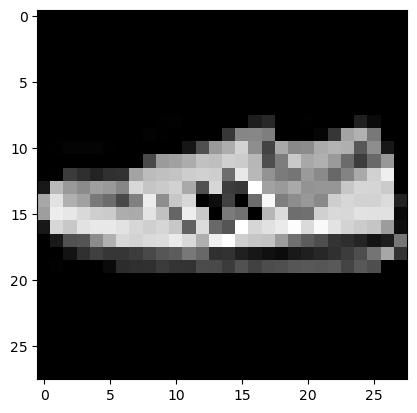

Label: 7


In [18]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")